In [12]:
import altair as alt

# saving data into a file rather than embedding into the chart
alt.data_transformers.enable('json') 
alt.renderers.enable('notebook')
# alt.renderers.enable('jupyterlab')
from vega_datasets import data
import pandas as pd
from altair import Scale,Color

In [13]:
file = 'annual_county_level.csv'

In [14]:
dforg = pd.read_csv(file,header=0)

In [15]:
dforg.head()

,Unnamed: 0,state,fips,year,BUYER_COUNTY,pills,population,Pill_per_pop
0,1,AK,2013,2006,ALEUTIANS EAST,300.0,2794,0.107373
1,2,AK,2013,2007,ALEUTIANS EAST,100.0,3012,0.033201
2,3,AK,2016,2006,ALEUTIANS WEST,26700.0,5658,4.718982
3,4,AK,2016,2007,ALEUTIANS WEST,33500.0,5466,6.128796
4,5,AK,2016,2008,ALEUTIANS WEST,30000.0,5393,5.562767


In [82]:
fdf = dforg[['fips','year','Pill_per_pop','BUYER_COUNTY','state']]

In [119]:
fdf['Pill_per_pop'] = fdf["Pill_per_pop"].astype(int)
fdf['BUYER_COUNTY'] = fdf["BUYER_COUNTY"].astype(str)
fdf['state'] = fdf["state"].astype(str)
fdf[fdf.Pill_per_pop>150] = 150

C:\Users\Satya\Anaconda3\envs\dviz\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Satya\Anaconda3\envs\dviz\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Satya\Anaconda3\envs\dviz\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [171]:
dummy = 'nothing'

In [183]:
import matplotlib
from matplotlib import *
# Mention the color scheme/map you are using currently
cmap = cm.get_cmap('viridis_r', 15)
cutoff = 0
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))
    if i == cutoff:
        dummy = matplotlib.colors.rgb2hex(rgb)

#fde725
#d0e11c
#a0da39
#73d056
#4ac16d
#2db27d
#1fa187
#21908d
#277f8e
#2e6e8e
#365c8d
#3f4788
#46327e
#481b6d
#440154


In [190]:
dummy = '#EEFBB3'

In [191]:
def choropleth(data,level,year=2006,scheme='yellowgreenblue',dummy=dummy,stroke='black',strokeWidth=0.05,type='linear',fips='fips'):
    chart = alt.Chart(level).mark_geoshape(
        stroke=stroke,
        strokeWidth=strokeWidth
    ).project(
        type='albersUsa'
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(data, fips, ['year','Pill_per_pop','BUYER_COUNTY','state'])
    ).transform_calculate(
        Pill_per_pop='isValid(datum.Pill_per_pop) ? datum.Pill_per_pop : -1'  
    ).encode(
        color = alt.condition(
            'datum.Pill_per_pop > 0',
            alt.Color('Pill_per_pop:Q', scale=Scale(scheme=scheme,type=type)),
            alt.value(dummy)
            ),
        tooltip=['BUYER_COUNTY:N', 'state:N','Pill_per_pop:Q','year:Q']
    ).properties(
        width=700,
        height=400,
        title='Pills per 100k people, {}'.format(year)
    )
    return chart

In [192]:
states = alt.topo_feature(data.us_10m.url, 'states')
counties = alt.topo_feature(data.us_10m.url+'#', 'counties')

In [193]:
def plot_year(year,fdf=fdf,counties=counties,states=states,state_stroke='black',state_strokew=0.15):
    fdf1 = fdf[fdf.year==year]
    chart = choropleth(fdf1,counties,year=year)
    
    outline = alt.Chart(states).mark_geoshape(stroke=state_stroke,strokeWidth=state_strokew).project(
    type='albersUsa'
    )
    
    return chart+outline

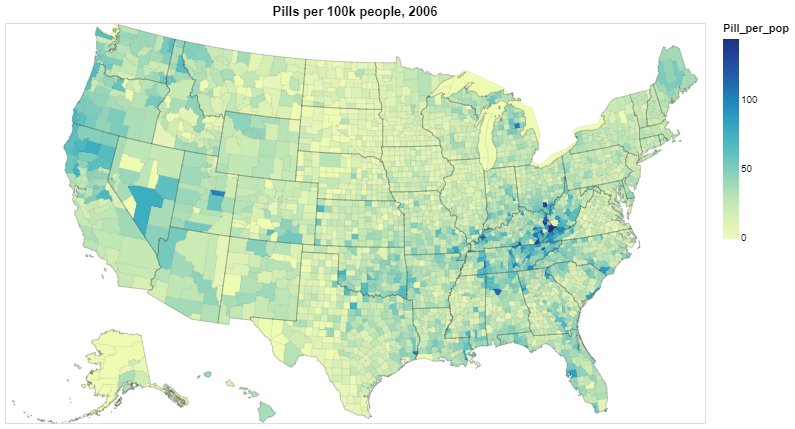

In [194]:
plot_year(2006)

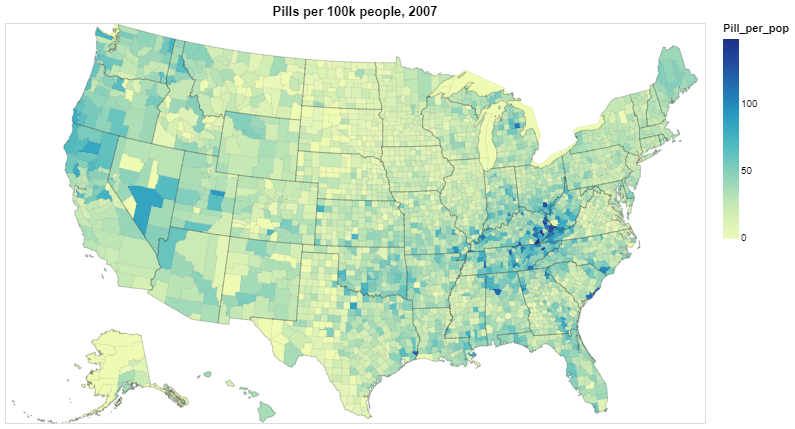

In [195]:
plot_year(2007)

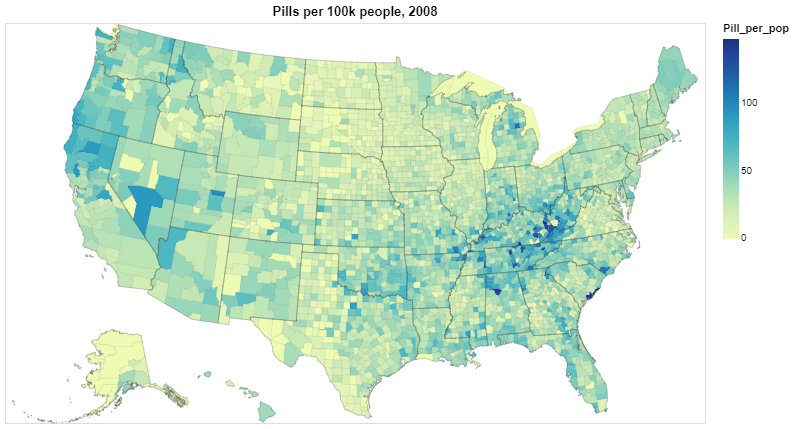

In [196]:
plot_year(2008)

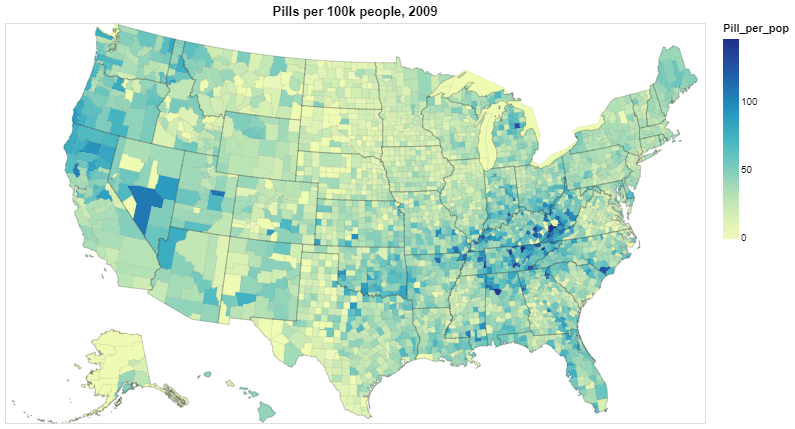

In [197]:
plot_year(2009)

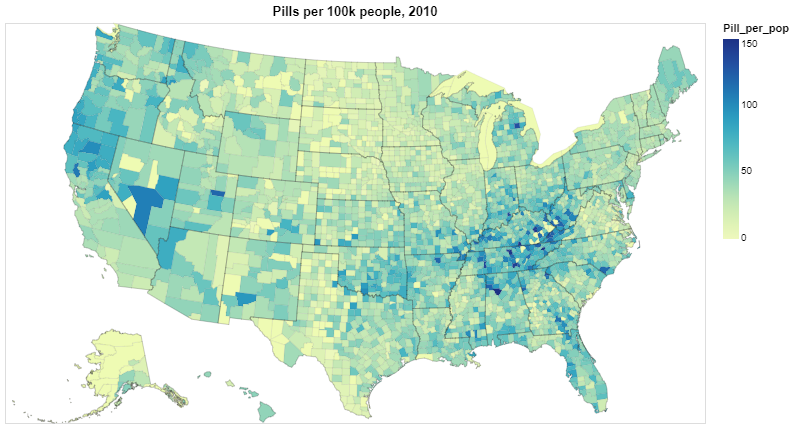

In [198]:
plot_year(2010)

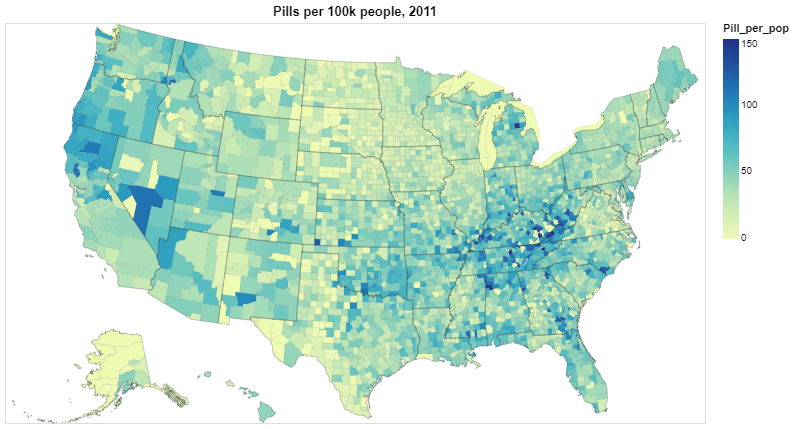

In [199]:
plot_year(2011)

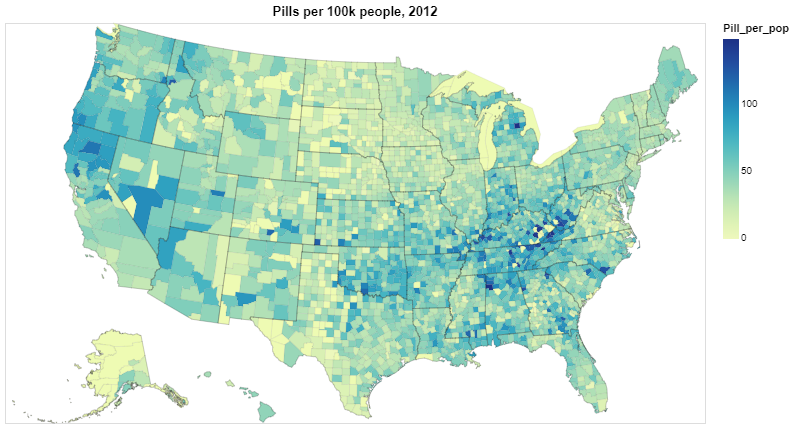

In [200]:
plot_year(2012)

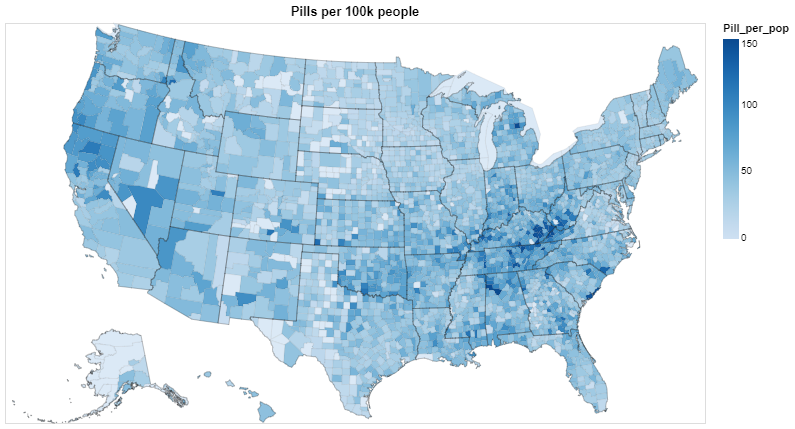

In [201]:
dummy='#dbe9f6'
scheme='blues'
type1='linear'

fg = alt.Chart(counties).mark_geoshape(
        stroke='black',
        strokeWidth=0.05
    ).project(
        type='albersUsa'
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(fdf, 'fips', ['year','Pill_per_pop','BUYER_COUNTY', 'state'])
    ).transform_calculate(
        Pill_per_pop='isValid(datum.Pill_per_pop) ? datum.Pill_per_pop : -1'  
    ).encode(
        color = alt.condition(
            'datum.Pill_per_pop > 0',
            alt.Color('Pill_per_pop:Q', scale=Scale(scheme=scheme,type=type1)),
            alt.value(dummy)
            ),
        tooltip=['BUYER_COUNTY:N', 'state:N','Pill_per_pop:Q','year:Q']
    ).properties(
        width=700,
        height=400,
        title='Pills per 100k people'
)

outline = alt.Chart(states).mark_geoshape(stroke='black',strokeWidth=0.2).project(
    type='albersUsa'
    )

fg+outline